<a href="https://colab.research.google.com/github/Gaurav-phatkare/BERT_Model-NLP/blob/main/Twitter_Sentiment_Analysis_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kazanova/sentiment140

100% 80.9M/80.9M [00:04<00:00, 25.5MB/s]
100% 80.9M/80.9M [00:04<00:00, 18.6MB/s]


In [7]:
!unzip /content/sentiment140.zip

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [8]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)

In [9]:
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']

In [10]:
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

In [11]:
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
# df = df.rename(columns={df.columns[0]: 'target', df.columns[1]: 'id', df.columns[2]: 'date', df.columns[3]: 'query', df.columns[4]: 'username', df.columns[5]: 'content'})

In [13]:
df.shape

(1600000, 2)

In [14]:
# df = df[['target','content']]

In [15]:
df['labels'] = df['Sentiment'].replace([0, 4],['Negative','Positive'])

In [16]:
df.Sentiment.value_counts()

0    800000
4    800000
Name: Sentiment, dtype: int64

In [17]:
df['Sentiment'] = df.Sentiment.replace(4,1)

In [18]:
df.Sentiment.value_counts()

0    800000
1    800000
Name: Sentiment, dtype: int64

#Data Cleaning

In [19]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    # text = mentions.sub(' entity', text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text.strip().lower()

In [20]:
df['Tweet'] = df.Tweet.apply(process_text)

In [21]:
df.head()

,Sentiment,Tweet,labels
0,0,"- awww, that's a bummer. you shoulda got davi...",Negative
1,0,is upset that he can't update his facebook by ...,Negative
2,0,i dived many times for the ball. managed to sa...,Negative
3,0,my whole body feels itchy and like its on fire,Negative
4,0,"no, it's not behaving at all. i'm mad. why am ...",Negative


In [22]:
df['Tweet'][-5:].values

array(['just woke up. having no school is the best feeling ever',
       'thewdb.com - very cool to hear old walt interviews!  â\x99«',
       'are you ready for your mojo makeover? ask me for details',
       'happy 38th birthday to my boo of alll time!!! tupac amaru shakur',
       'happy hashtag'], dtype=object)

In [23]:
df.drop_duplicates(subset='Tweet',inplace=True)

In [24]:
df.shape

(1541247, 3)

In [25]:
text_len = []
for text in df.Tweet:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [26]:
df['text_len'] = text_len

In [27]:
df.head()

,Sentiment,Tweet,labels,text_len
0,0,"- awww, that's a bummer. you shoulda got davi...",Negative,17
1,0,is upset that he can't update his facebook by ...,Negative,21
2,0,i dived many times for the ball. managed to sa...,Negative,17
3,0,my whole body feels itchy and like its on fire,Negative,10
4,0,"no, it's not behaving at all. i'm mad. why am ...",Negative,20


In [28]:
df = df[df['text_len'] > 4]

In [29]:
df.shape

(1394620, 4)

In [30]:
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

In [31]:
training_data.shape, testing_data.shape

((1115696, 4), (278924, 4))

In [32]:
import tensorflow as tf
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00


In [33]:
from transformers import BertTokenizerFast
from transformers import TFBertModel

In [34]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [35]:
token_lens = []

for txt in training_data['Tweet'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [36]:
max_len

212

In [37]:
training_data['token_lens'] = token_lens

In [38]:
training_df = training_data.sort_values(by='token_lens', ascending=False)

In [39]:
training_df[:1000]

,Sentiment,Tweet,labels,text_len,token_lens
709142,0,à¶¶à¶½à·?à¶à·à¶± à·à¶»à· à¶ºà¶±à·à¶±à· à...,Negative,20,212
1188208,1,à¤à¤¾à¤¨ à¤à¤¤à¤¾ à¥¨ à¤¦à¤¿à¤µà¤¸ à¤¸à¥?à¤...,Positive,25,175
443960,0,firefly ñ?ñð¾ ðºð°ðºð°ñ?-ñð¾ ñ?ð¾ð²ðµññðµð...,Negative,19,173
325649,0,"ð´ð¸ñ?ðº ð½ðµ ð¿ñð¾ð²ðµññ?ð», ð½ðµ ð·ð½ð°ñ....",Negative,21,170
368825,0,ð¥ð¼ð¼... ð¯ ð±ñ ñð¾ð¶ðµ ð½ðµ ð¾ñðºð°ð·ð°ð»...,Negative,20,162
...,...,...,...,...,...
738105,0,gd owes me hugs..... ..... ugh no its okay ...,Negative,25,59
969284,1,"secondly, i saw the funniest musical ever...&q...",Positive,25,59
1579263,1,cheaper comics from today. $3.99 comics now â£...,Positive,23,59
696353,0,just cut my hair!omg!so shortt.haha.so ur not ...,Negative,22,59


In [40]:
training_df = training_df.iloc[1500:]

In [41]:
training_df.shape

(1114196, 5)

In [42]:
training_df = training_df.sample(frac=1).reset_index(drop=True)

<ipython-input-43-35caff79e668>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(training_df['token_lens'])


<Axes: xlabel='token_lens', ylabel='Density'>

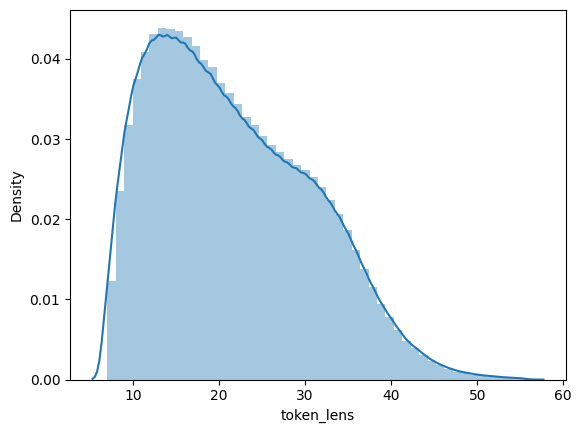

In [43]:
sns.distplot(training_df['token_lens'])

In [44]:
token_lens_test = []

for txt in testing_data['Tweet'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [45]:
max_len

230

In [46]:
testing_data['token_lens'] = token_lens_test

In [47]:
testing_df = testing_data.sort_values(by='token_lens', ascending=False)
testing_df.head(1500)

,Sentiment,Tweet,labels,text_len,token_lens
1582941,1,5 days till new top gear î?î?î?î?î?î?î?...,Positive,7,230
1324105,1,ð?ðµ ð¼ð¾ð³ñ ñ?ðºð°ð·ð°ññ ð¾ ñð¾ð¿-ð¼ðµð½ð...,Positive,21,172
1325631,1,ññ ñ?ðºð¾ñðµðµ ð¿ð¾ñðµññ?ðµññ ð¸ð»ð¸ ð¿...,Positive,18,167
1484492,1,ð´ð°ð¶ðµ ð¸ ð½ðµ ð¿ð¾ð´ð¾ð·ñðµð²ð°ð¹ ð¼ðµð½ñ?...,Positive,20,163
248973,0,"ð?ññ, openoffice ð²ñð±ðµñ?ð¸ð» ñ?ð²ð¾ðµð¹ ð...",Negative,17,159
...,...,...,...,...,...
880751,1,me: &quot;oh hey we are having a laptop party!...,Positive,21,48
374573,0,woohoo-ing over the good news i just got and b...,Negative,26,48
976412,1,"oui oui and i saw you, and i said to bec 'hey...",Positive,29,48
1068392,1,"omg, i saw the &quot;trailer&quot; of new moon...",Positive,27,48


In [48]:
testing_df = testing_df.iloc[1500:]
testing_df.head(10)

,Sentiment,Tweet,labels,text_len,token_lens
10062,0,i wanna get 93841934431984139418349134 dvd's.....,Negative,20,48
1228966,1,"2day, i'm very gd! i was thinking abt u when ...",Positive,21,48
726288,0,i said i need it ----no me's now need sleep......,Negative,20,48
1504924,1,on the phone with the babes. thinking. i been ...,Positive,22,48
246272,0,i remember i could not wait for my bday when i...,Negative,26,48
383432,0,what?? ga bole pke make up duluw sampe senin? ...,Negative,21,48
675597,0,i missed their recent shows here in hashtag a...,Negative,24,48
338525,0,dammmm u need to move in with me....lol... ill...,Negative,21,48
355049,0,i'm really tired...the &quot;not sick&quot; ca...,Negative,27,48
167718,0,"pinkpop weekend &amp; i've got no tickets, mea...",Negative,15,48


In [49]:
testing_df = testing_df.sample(frac=1).reset_index(drop=True)

In [50]:
testing_df.head(10)

,Sentiment,Tweet,labels,text_len,token_lens
0,0,going to watch drag me to hell with my sis.......,Negative,16,23
1,0,im so tired... want to go home,Negative,7,12
2,0,i hate being irish and having plae skin that b...,Negative,13,16
3,1,hey the pacific highway at pymble.,Positive,6,11
4,1,i once had his lyrics memorized.. sad to say t...,Positive,14,20
5,1,omg you have twilight background for twitter?!...,Positive,9,19
6,1,hehe! gabe just told me that asuar bought ava ...,Positive,16,26
7,1,"just went on a shopping spree, mum brought me ...",Positive,16,22
8,1,we broke 1k downloads. 158 from mediafire and...,Positive,15,22
9,1,"haha twitter, i have won this battle, u wont b...",Positive,15,25


In [51]:
training_df.Sentiment.value_counts()

0    568761
1    545435
Name: Sentiment, dtype: int64

In [52]:
X = training_df['Tweet'].values
y = training_df['Sentiment'].values

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [54]:
X_test = testing_df['Tweet'].values
y_test = testing_df['Sentiment'].values

In [55]:
X_train.shape[0], X_val.shape, X_test.shape

(1002776, (111420,), (277424,))

# One Hot Encoding

In [56]:
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

In [57]:
from sklearn import preprocessing

OneHot = preprocessing.OneHotEncoder()
y_train = OneHot.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = OneHot.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = OneHot.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# Baseline Model With Naive Bayes and TFIDF

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


# Create tokenization and modelling pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',MultinomialNB())
])

# fit the pipeline to the training data

model_0.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [59]:
baseline_score = model_0.score(X_val, y_val)

In [60]:
baseline_score

0.7639023514629331

In [61]:
test_pred = model_0.predict(X_test)

In [62]:
y_test_le

array([0, 0, 0, ..., 1, 1, 1])

In [63]:
# make helper function for accuracy precision recall and f1 score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le, test_pred, target_names = ['Negative', 'Positive']))




	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.76      0.80      0.78    142006
    Positive       0.78      0.73      0.75    135418

    accuracy                           0.77    277424
   macro avg       0.77      0.76      0.76    277424
weighted avg       0.77      0.77      0.76    277424



#BERT Sentiment Analysis

In [64]:
Max_len = 128

In [65]:
def tokenize(data, max_len = Max_len):
  input_ids = []
  attention_masks = []

  for i in range(len(data)):
    encoded = tokenizer.encode_plus(
    data[i],
    add_special_tokens = True,
    max_length = max_len,
    padding = 'max_length',
    return_attention_mask = True
    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids), np.array(attention_masks)

In [66]:
train_input_ids, train_attention_masks = tokenize(X_train, Max_len)
val_input_ids, val_attention_masks = tokenize(X_val, Max_len)
test_input_ids, test_attention_masks = tokenize(X_test, Max_len)


array([[  101,  4654, 28939, ...,     0,     0,     0],
       [  101,  2074,  2736, ...,     0,     0,     0],
       [  101,  2008,  1010, ...,     0,     0,     0],
       ...,
       [  101,  2033,  2205, ...,     0,     0,     0],
       [  101,  1011,  2035, ...,     0,     0,     0],
       [  101,  2572,  2025, ...,     0,     0,     0]])

In [67]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [73]:
# let build the model

input_ids = tf.keras.Input(shape = (128,), dtype = 'int32')
attention_masks = tf.keras.Input(shape = (128,), dtype = 'int32')

embeddings = bert_model([input_ids, attention_masks])[1]

output = tf.keras.layers.Dense(2, activation = 'softmax')(embeddings)

model = tf.keras.models.Model(inputs = [input_ids, attention_masks],
                              outputs = output)

In [72]:
# def create_model(bert_model, max_len = Max_len):
#   opt = tf.keras.optimizers.Adam()
#   loss = tf.keras.losses.CategoricalCrossentropy()
#   accuracy = tf.keras.metrics.CategoricalAccuracy()


#   input_ids = tf.keras.Input(shape = (Max_len,), dtype = 'int32')
#   attention_masks = tf.keras.Input(shape = (Max_len,), dtype = 'int32')

#   embeddings = bert_model([input_ids, attention_masks])[1]

#   output = tf.keras.layers.Dense(2, activation = 'softmax')(embeddings)

#   model = tf.keras.models.Model(inputs = [input_ids, attention_masks],
#                               outputs = output)

#   model.compile(opt, loss = loss, metrics = accuracy)

#   return model




In [74]:
# compile the model
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = tf.keras.metrics.CategoricalAccuracy())

In [75]:
# model = create_model(bert_model, Max_len)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [78]:
history_bert_model = model.fit([train_input_ids,  train_attention_masks],
                               y_train,
                               validation_data = ([val_input_ids, val_attention_masks],y_val),
                               epochs = 4,
                               batch_size = 32)

Epoch 1/4
  125/31337 [..............................] - ETA: 6:17:28 - loss: 0.7921 - categorical_accuracy: 0.4952

KeyboardInterrupt: ignored

In [ ]:
train_input_ids.shape

In [ ]:
tf.expand_dims(train_input_ids,axis=-1).shape

In [ ]:
y_train.shape